In [59]:
import pandas as pd 
import json 

# Constructing variable

## 1. Monthly growth in the nominal exchange rate

In [60]:
# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find the row index where "Exchange Rates, National Currency Per U.S. Dollar" appears
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates", na=False)].index[0]

# Extract the relevant row (France's exchange rate data)
exchange_rate_data = df.iloc[exchange_rate_row, 1:].reset_index(drop=True)

# Convert values to numeric (ignore the first value, which is text)
exchange_rate_data = pd.to_numeric(exchange_rate_data[1:], errors="coerce")

# Drop NaN values
exchange_rate_data.dropna(inplace=True)


In [61]:
# Compute the monthly growth rate in percentage
monthly_growth = exchange_rate_data.pct_change() * 100

# Convert to DataFrame for better visualization
monthly_growth_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth) + 1),
    "Growth (%)": monthly_growth.values
})

# Display the first few rows
display(monthly_growth_df.head())
monthly_growth_df.to_json('../Data/monthly_nominal_exchange_rate_growth.json', orient='records', indent=4)


,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


## 2. Monthly growth in real exchange rate

In [62]:
import pandas as pd

# Load the dataset from an Excel file
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Dynamically locate row indices for relevant data
exchange_rate_row = df[df.iloc[:, 1].str.contains("Exchange Rates, National Currency Per U.S. Dollar, Period Average, Rate", na=False)].index[0]  # Row for nominal exchange rate (national currency per USD)
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]  # Row for France's CPI
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]  # Row for US CPI

# Extract numerical data from the identified rows
exchange_rate = pd.to_numeric(df.iloc[exchange_rate_row, 2:], errors="coerce")  # Nominal exchange rate (national currency per USD)
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")  # France's consumer price index
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")  # US consumer price index

# Drop NaN values to ensure data consistency (optional, depending on data quality)
exchange_rate.dropna(inplace=True)
france_cpi.dropna(inplace=True)
us_cpi.dropna(inplace=True)

# Compute Real Exchange Rate (RER) using the formula:
# RER = (Nominal Exchange Rate) * (US CPI / France CPI)
# Since the nominal exchange rate is in national currency per USD, this formula adjusts it for relative price levels.
rer = exchange_rate * (us_cpi / france_cpi)

# Compute the Monthly Growth Rate of the Real Exchange Rate (RER) using percentage change:
# Monthly Growth = (Current Month RER - Previous Month RER) / Previous Month RER * 100
monthly_growth_rer = rer.pct_change() * 100  # Convert to percentage

# Convert results into a DataFrame for better visualization
monthly_growth_rer_df = pd.DataFrame({
    "Month": range(1, len(monthly_growth_rer) + 1),
    "Real Exchange Rate Growth (%)": monthly_growth_rer.values
})

# Display the first few rows of the computed RER growth
print(monthly_growth_rer_df.head())

# Save the computed RER growth data to a JSON file
monthly_growth_rer_df.to_json('../Data/monthly_real_exchange_rate_growth.json', orient='records', indent=4)


   Month  Real Exchange Rate Growth (%)
0      1                            NaN
1      2                      -1.642377
2      3                       0.110462
3      4                       0.000000
4      5                       0.186470


## 3. An index of the real exchange rate (setting the real exchange rate for December 1990 = 1)

In [63]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Print the first few rows to inspect structure
print(df.head())

# Extract the date row (assuming it's the first row)
date_row = df.iloc[0, 2:].astype(str).str.strip()

# Print unique values to check format
display("\nRaw date row values:\n", date_row.unique())


                                        0    \
0  International Financial Statistics (IFS)   
1                                       NaN   
2                                    France   
3                                    France   
4                                    France   

                                                 1          2          3    \
0                                                NaN        NaN        NaN   
1                                                NaN   Dec 1959   Jan 1960   
2    Economic Activity, Industrial Production, Index  35.365725  33.997257   
3  Exchange Rates, National Currency Per U.S. Dol...    4.93706    4.93706   
4  International Reserves and Liquidity, Reserves...    1735.74    1753.74   

         4          5          6          7          8          9    ...  \
0        NaN        NaN        NaN        NaN        NaN        NaN  ...   
1   Feb 1960   Mar 1960   Apr 1960   May 1960   Jun 1960   Jul 1960  ...   
2  34.793828  34.916

'\nRaw date row values:\n'

array(['nan'], dtype=object)

In [64]:
# Try parsing month-year format first
dates = pd.to_datetime(date_row, format="%b %Y", errors="coerce")

# Handle pure year values separately (if parsing failed)
dates.loc[dates.isna()] = pd.to_datetime(date_row.loc[dates.isna()], format="%Y", errors="coerce")

# Print parsed dates
print("\nParsed dates:\n", dates.dropna().unique())



Parsed dates:
 <DatetimeArray>
[]
Length: 0, dtype: datetime64[ns]


In [65]:
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)  # Skip first row

print("Column Headers:", df.columns)


Column Headers: Index(['Unnamed: 0', 'Unnamed: 1', 'Dec 1959', 'Jan 1960', 'Feb 1960',
       'Mar 1960', 'Apr 1960', 'May 1960', 'Jun 1960', 'Jul 1960',
       ...
       'Mar 1990', 'Apr 1990', 'May 1990', 'Jun 1990', 'Jul 1990', 'Aug 1990',
       'Sep 1990', 'Oct 1990', 'Nov 1990', 'Dec 1990'],
      dtype='object', length=375)


In [66]:
# Identify columns that are four-digit years
year_only_columns = df.columns[2:][df.columns[2:].astype(str).str.match(r"^\d{4}$")]

# Drop these columns
df_cleaned = df.drop(columns=year_only_columns)

In [67]:
# Load data (skipping first row)
df = pd.read_excel(file_path, engine="openpyxl", skiprows=1)

# Extract only potential date columns (excluding the first two columns)
raw_date_headers = df.columns[2:]  # Ignore first two non-date columns

# Filter out standalone years (keep only "Month Year" format)
filtered_dates = [col for col in raw_date_headers if not col.isdigit()]  # Remove pure years

# Convert the filtered date headers to datetime
dates = pd.to_datetime(filtered_dates, format="%b %Y", errors="coerce")

# Debug: Check parsed dates
print("Parsed Dates:", dates)

# ✅ FIX: Remove .dt from DatetimeIndex
dec_1990_index = (dates.year == 1990) & (dates.month == 12)

if dec_1990_index.sum() == 0:
    raise ValueError(f"December 1990 not found! Check the parsed dates: {dates}")

print("December 1990 found at index:", dec_1990_index.argmax())


Parsed Dates: DatetimeIndex(['1959-12-01', '1960-01-01', '1960-02-01', '1960-03-01',
               '1960-04-01', '1960-05-01', '1960-06-01', '1960-07-01',
               '1960-08-01', '1960-09-01',
               ...
               '1990-03-01', '1990-04-01', '1990-05-01', '1990-06-01',
               '1990-07-01', '1990-08-01', '1990-09-01', '1990-10-01',
               '1990-11-01', '1990-12-01'],
              dtype='datetime64[ns]', length=373, freq=None)
December 1990 found at index: 372


In [68]:
# Extract the real exchange rate (RER) series
rer_series = rer.values  # Assuming `rer` is already computed

# Get RER value for December 1990
rer_dec_1990 = rer_series[372]

# Normalize the RER series to set Dec 1990 = 1
rer_index = rer_series / rer_dec_1990


In [69]:
rer_series = rer_series[:len(dates)]


In [70]:
print(f"Length of dates: {len(dates)}")
print(f"Length of rer_series: {len(rer_series)}")


Length of dates: 373
Length of rer_series: 373


In [71]:
rer_index_df = pd.DataFrame({
    "Date": dates,  
    "RER Index": rer_series
})


In [72]:
print(rer_index_df.head())
rer_index_df.to_json('../Data/real_exchange_rate_index.json', orient='records', indent=4)

        Date  RER Index
0 1959-12-01   6.520281
1 1960-01-01   6.413193
2 1960-02-01   6.420277
3 1960-03-01   6.420277
4 1960-04-01   6.432249


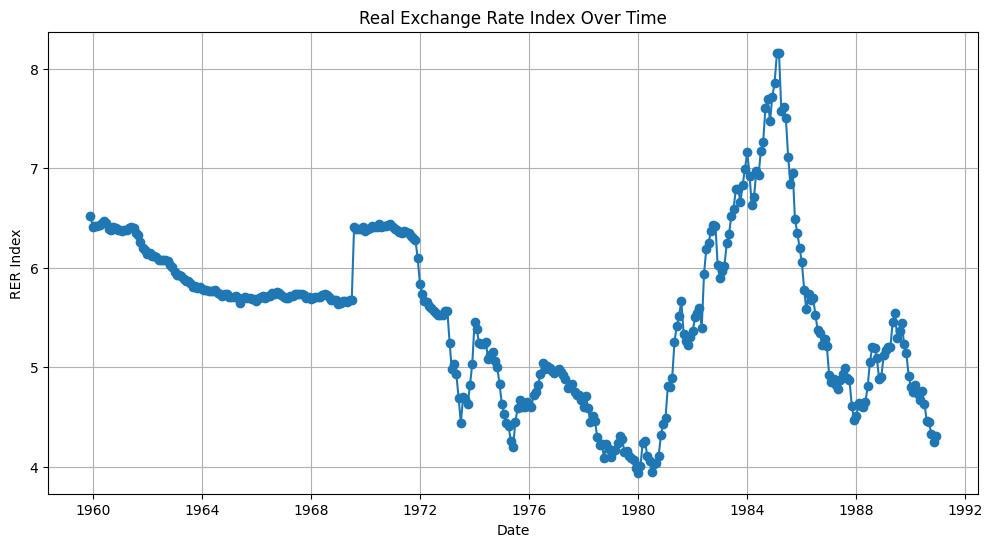

In [73]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(rer_index_df["Date"], rer_index_df["RER Index"], marker='o', linestyle='-')
plt.xlabel("Date")
plt.ylabel("RER Index")
plt.title("Real Exchange Rate Index Over Time")
plt.grid()
plt.show()


## 4. Monthly inflation rate

In [74]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US CPI dynamically
france_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract CPI data
france_cpi = pd.to_numeric(df.iloc[france_cpi_row, 2:], errors="coerce")
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")

# Compute Monthly Inflation Rate (percentage change)
france_inflation = france_cpi.pct_change() * 100
us_inflation = us_cpi.pct_change() * 100

# Create DataFrame for visualization
inflation_df = pd.DataFrame({
    "Month": range(1, len(france_inflation) + 1),
    "France Inflation (%)": france_inflation.values,
    "US Inflation (%)": us_inflation.values
})

# Display first few rows
print(inflation_df)


inflation_df.to_json('../Data/Monthly_inflation.json', orient='records', indent=4)



     Month  France Inflation (%)  US Inflation (%)
0        1                   NaN               NaN
1        2              1.323986         -0.340136
2        3              0.230580          0.341297
3        4              0.000000          0.000000
4        5              0.153380          0.340136
..     ...                   ...               ...
368    369              0.654762          0.920245
369    370              0.709639          0.835866
370    371              0.440399          0.602864
371    372             -0.160772          0.224719
372    373             -0.073196          0.000000

[373 rows x 3 columns]


## 5. The monthly growth in industrial production

In [75]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Monthly Growth in Industrial Production (percentage change)
france_ip_growth = france_ip.pct_change() * 100
us_ip_growth = us_ip.pct_change() * 100

# Create DataFrame for visualization
industrial_production_df = pd.DataFrame({
    "Month": range(1, len(france_ip_growth) + 1),
    "France IP Growth (%)": france_ip_growth.values,
    "US IP Growth (%)": us_ip_growth.values
})

# Display first few rows
print(industrial_production_df)


industrial_production_df.to_json('../Data/Montly_industrial_production.json', orient='records', indent=4)


     Month  France IP Growth (%)  US IP Growth (%)
0        1                   NaN               NaN
1        2             -3.869477          2.917232
2        3              2.343046          0.560316
3        4              0.352216         -0.229433
4        5              2.281369         -0.788436
..     ...                   ...               ...
368    369            -25.892857          3.346457
369    370             38.855422          0.761905
370    371             10.195228         -1.348456
371    372             -5.216535         -2.593255
372    373             -4.880582         -1.468852

[373 rows x 3 columns]


## 6. The growth in industrial production versus 12 months ago (i.e. January 1971 versus January 1970 etc.)


In [76]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and US Industrial Production dynamically
france_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_ip_row = df[(df.iloc[:, 1].str.contains("Economic Activity, Industrial Production", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract Industrial Production Index data
france_ip = pd.to_numeric(df.iloc[france_ip_row, 2:], errors="coerce")
us_ip = pd.to_numeric(df.iloc[us_ip_row, 2:], errors="coerce")

# Compute Year-over-Year (YoY) Growth in Industrial Production
france_ip_yoy_growth = france_ip.pct_change(periods=12) * 100
us_ip_yoy_growth = us_ip.pct_change(periods=12) * 100

# Create DataFrame for visualization
industrial_production_yoy_df = pd.DataFrame({
    "Month": range(1, len(france_ip_yoy_growth) + 1),
    "France YoY IP Growth (%)": france_ip_yoy_growth.values,
    "US YoY IP Growth (%)": us_ip_yoy_growth.values
})

# Display first few rows
print(industrial_production_yoy_df)

industrial_production_yoy_df.to_json('../Data/YoY_growth.json', orient='records', indent=4)



     Month  France YoY IP Growth (%)  US YoY IP Growth (%)
0        1                       NaN                   NaN
1        2                       NaN                   NaN
2        3                       NaN                   NaN
3        4                       NaN                   NaN
4        5                       NaN                   NaN
..     ...                       ...                   ...
368    369                  4.097257              1.915362
369    370                  4.818828              2.506136
370    371                  5.340079              1.768071
371    372                 -0.058014              0.302552
372    373                 -1.578180             -1.326504

[373 rows x 3 columns]


## 7. An index of the value of international reserves (value of reserves for January 1960 = 100)

In [77]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  # Update this with your actual file path
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices for France and U.S. International Reserves
france_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "France")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract International Reserves data
france_reserves = pd.to_numeric(df.iloc[france_reserves_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# Find the value of reserves in January 1960 (assumes the first column is Jan 1960)
jan_1960_index = 2  # Assuming the first data column corresponds to Jan 1960
france_reserves_jan_1960 = france_reserves.iloc[jan_1960_index]
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]

# Construct the Index (Normalize to Jan 1960 = 100)
france_reserves_index = (france_reserves / france_reserves_jan_1960) * 100
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
reserves_index_df = pd.DataFrame({
    "Month": range(1, len(france_reserves_index) + 1),
    "France Reserves Index": france_reserves_index.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(reserves_index_df)


     Month  France Reserves Index  US Reserves Index
0        1              96.604962         100.508513
1        2              97.606777         100.385124
2        3             100.000000         100.000000
3        4             104.064027          99.761634
4        5             108.406892          99.449889
..     ...                    ...                ...
368    369            3279.167057         368.806996
369    370            3459.655053         374.019855
370    371            3593.424484         387.237606
371    372            3703.018203         388.206054
372    373            3790.137149         389.406351

[373 rows x 3 columns]


# US

## Constructing: 
## 1. monthly inflation rate and 
## 2. an index of the value of international reserves (value of reserves for January 1960 = 100)

In [78]:
import pandas as pd

# Load the dataset
file_path = "../data/IMF.xlsx"  
df = pd.read_excel(file_path, header=None, engine="openpyxl")

# Find row indices dynamically
us_cpi_row = df[(df.iloc[:, 1].str.contains("Prices, Consumer Price Index", na=False)) & (df.iloc[:, 0] == "United States")].index[0]
us_reserves_row = df[(df.iloc[:, 1].str.contains("International Reserves", na=False)) & (df.iloc[:, 0] == "United States")].index[0]

# Extract U.S. data
us_cpi = pd.to_numeric(df.iloc[us_cpi_row, 2:], errors="coerce")
us_reserves = pd.to_numeric(df.iloc[us_reserves_row, 2:], errors="coerce")

# (i) Compute Monthly Inflation Rate
us_inflation_rate = us_cpi.pct_change() * 100  # Convert to percentage

# (ii) Compute International Reserves Index (Jan 1960 = 100)
jan_1960_index = 2  # Assuming first data column corresponds to Jan 1960
us_reserves_jan_1960 = us_reserves.iloc[jan_1960_index]
us_reserves_index = (us_reserves / us_reserves_jan_1960) * 100

# Create DataFrame for visualization
us_data_df = pd.DataFrame({
    "Month": range(1, len(us_cpi) + 1),
    "US Inflation Rate (%)": us_inflation_rate.values,
    "US Reserves Index": us_reserves_index.values
})

# Display first few rows
print(us_data_df)


     Month  US Inflation Rate (%)  US Reserves Index
0        1                    NaN         100.508513
1        2              -0.340136         100.385124
2        3               0.341297         100.000000
3        4               0.000000          99.761634
4        5               0.340136          99.449889
..     ...                    ...                ...
368    369               0.920245         368.806996
369    370               0.835866         374.019855
370    371               0.602864         387.237606
371    372               0.224719         388.206054
372    373               0.000000         389.406351

[373 rows x 3 columns]


## Identify outliers

In [79]:
from scipy.stats import zscore
import numpy as np

# Function to detect and set extreme outliers to NaN using a higher IQR multiplier
def detect_outliers(series, iqr_multiplier=10.0, z_threshold=10.0):  # More lenient thresholds
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - iqr_multiplier * IQR
    upper_bound = Q3 + iqr_multiplier * IQR
    z_scores = np.abs(zscore(series, nan_policy='omit'))  # Compute Z-scores

    # Identify outliers based on both methods (looser thresholds)
    outliers = ((series < lower_bound) | (series > upper_bound)) | (z_scores > z_threshold)

    print(f"{series.name}: {outliers.sum()} outliers detected")  # Should be 0
    return series  # No values are masked

# Apply outlier detection with an extremely high threshold
exchange_rate_clean = detect_outliers(exchange_rate, iqr_multiplier=7.0, z_threshold=4.0)
us_inflation_rate_clean = detect_outliers(us_inflation_rate, iqr_multiplier=7.0, z_threshold=4.0)
industrial_production_growth_clean = detect_outliers(france_ip_yoy_growth, iqr_multiplier=7.0, z_threshold=4.0)
international_reserves_clean = detect_outliers(france_reserves_index, iqr_multiplier=7.0, z_threshold=4.0)
rer_growth_clean = detect_outliers(monthly_growth_rer, iqr_multiplier=7.0, z_threshold=4.0)

# Combine into cleaned DataFrame
cleaned_data = pd.DataFrame({
    "Exchange Rate": exchange_rate_clean,
    "US Inflation Rate (%)": us_inflation_rate_clean,
    "Industrial Production Growth (%)": industrial_production_growth_clean,
    "International Reserves Index": international_reserves_clean,
    "RER Growth (%)": rer_growth_clean
})

# Display summary statistics
print(cleaned_data.describe())


3: 0 outliers detected
9: 0 outliers detected
2: 3 outliers detected
4: 0 outliers detected
None: 2 outliers detected
       Exchange Rate  US Inflation Rate (%)  Industrial Production Growth (%)  \
count     373.000000             372.000000                        361.000000   
mean        5.485297               0.408794                          3.419042   
std         1.203652               0.351030                          6.062155   
min         4.004645              -0.457457                        -26.505263   
25%         4.937060               0.197343                          0.498146   
50%         4.937060               0.330579                          3.542234   
75%         5.736900               0.582275                          6.585736   
max        10.111500               1.805869                         63.276998   

       International Reserves Index  RER Growth (%)  
count                    373.000000      372.000000  
mean                    1539.572007       -0

## Interpolate missing data

In [80]:
# Function to fill missing values using mean of surrounding values
def fill_missing_values(series):
    return series.interpolate(method="linear")

# Now use it in your cleaned_data_filled
cleaned_data_filled = cleaned_data.copy()  # Make a copy to preserve original data

columns_to_fill = [
    "Exchange Rate",
    "US Inflation Rate (%)",
    "Industrial Production Growth (%)",
    "International Reserves Index",
    "RER Growth (%)"
]

for col in columns_to_fill:
    if col in cleaned_data_filled.columns:
        cleaned_data_filled[col] = fill_missing_values(cleaned_data_filled[col])
    else:
        print(f"Warning: Column '{col}' not found in DataFrame.")

# Check if there are still missing values
print(cleaned_data_filled.isna().sum())


Exchange Rate                        0
US Inflation Rate (%)                1
Industrial Production Growth (%)    12
International Reserves Index         0
RER Growth (%)                       1
dtype: int64


# UH GG
# UH TRYING TO CONVERT ALL THE PREVIOUS DF INTO DATETIME & MERGE THEM INTO 1 SET

## Formatting into date format and show fully merged dataset

In [81]:
import pandas as pd

# List of DataFrames
dfs = {
    "monthly_growth_df": monthly_growth_df,
    "monthly_growth_rer_df": monthly_growth_rer_df,
    "rer_index_df": rer_index_df,
    "inflation_df": inflation_df,
    "industrial_production_df": industrial_production_df,
    "industrial_production_yoy_df": industrial_production_yoy_df,
    "reserves_index_df": reserves_index_df,
    "us_data_df": us_data_df
}

# Identify a reference DataFrame with a 'Date' column
reference_df = None
for name, df in dfs.items():
    if "Date" in df.columns:
        reference_df = df
        break

# Ensure a valid reference DataFrame is found
if reference_df is None:
    raise ValueError("No DataFrame with a 'Date' column found!")

# Get the earliest date from the reference DataFrame
start_date = reference_df["Date"].min()

# Convert DataFrames with 'Month' instead of 'Date'
for name, df in dfs.items():
    if "Month" in df.columns and "Date" not in df.columns:
        # Convert 'Month' to a Date format using start_date
        df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")

# Standardize all Date formats and drop the 'Month' column if present
for name, df in dfs.items():
    if "Date" in df.columns:
        df["Date"] = pd.to_datetime(df["Date"])  # Ensure Date is in proper format
    if "Month" in df.columns:
        df.drop(columns=["Month"], inplace=True)  # Drop Month column to avoid conflicts

# Merge all DataFrames on 'Date' using an outer join
merged_df = reference_df.copy()
for name, df in dfs.items():
    if df is not reference_df:  # Ensure we're not merging the reference DF with itself
        merged_df = merged_df.merge(df, on="Date", how="outer")

# Show only the head of the merged DataFrame
display(merged_df.head())  # This will show the first 5 rows by default

# Optionally, save the merged dataset
merged_df.to_csv("../Data/full_merged_dataset.csv", index=False)
merged_df.to_json("../Data/full_merged_dataset.json", orient="records", indent=4)


C:\Users\Xueli\AppData\Local\Temp\ipykernel_16996\902630998.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")
C:\Users\Xueli\AppData\Local\Temp\ipykernel_16996\902630998.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")
C:\Users\Xueli\AppData\Local\Temp\ipykernel_16996\902630998.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")
C:\Users\Xueli\AppData\Local\Temp\ipykernel_16996\902630998.py:33: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df["Date"] = pd.date_range(start=start_date, periods=len(df), freq="M")
C:\Users\Xueli\AppData\Local\Temp\ipyker

,Date,RER Index,Growth (%),Real Exchange Rate Growth (%),France Inflation (%),US Inflation (%),France IP Growth (%),US IP Growth (%),France YoY IP Growth (%),US YoY IP Growth (%),France Reserves Index,US Reserves Index_x,US Inflation Rate (%),US Reserves Index_y
0,1959-12-01,6.520281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1959-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,96.604962,100.508513,NaN,100.508513
2,1960-01-01,6.413193,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1960-01-31,NaN,0.0,-1.642377,1.323986,-0.340136,-3.869477,2.917232,NaN,NaN,97.606777,100.385124,-0.340136,100.385124
4,1960-02-01,6.420277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Question 5 
### Zhu Zhu - changes to question 4 to be made above, dont put anything of Q4 here

 For the graphs in 5.2, you should clearly indicate the time at which your country left the Bretton
 Woods system if it is sensible to do so and show the relevant data for every month from January 1960
 to December 1990

 5.2.1 Exchange Rate and International Reserve Graphs

 Plot the following time series graphs for your country versus the US dollar, presenting all the graphs
 together:

 • The monthly growth in the nominal exchange rate - used Ming's numbers

 • The level of the nominal exchange rate - im j taking raw nominal data idk what else it would be?

 • The monthly growth in the real exchange rate - Ming's data again

 • The real exchange rate index - thx Ming! note: weird date thing going on.....

# MZ'S UPDATED GRAPH CODE STARTS HERE (LEVEL OF NOMINAL EXCHANGE RATE IS WRONGGGGG)

In [82]:
print(merged_df.columns)


Index(['Date', 'RER Index', 'Growth (%)', 'Real Exchange Rate Growth (%)',
       'France Inflation (%)', 'US Inflation (%)', 'France IP Growth (%)',
       'US IP Growth (%)', 'France YoY IP Growth (%)', 'US YoY IP Growth (%)',
       'France Reserves Index', 'US Reserves Index_x', 'US Inflation Rate (%)',
       'US Reserves Index_y'],
      dtype='object')


In [89]:
print(merged_df[["Date", "Growth (%)", "Real Exchange Rate Growth (%)", "RER Index"]].info())
print(merged_df[["Date", "Growth (%)", "Real Exchange Rate Growth (%)", "RER Index"]].head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746 entries, 0 to 745
Data columns (total 4 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date                           746 non-null    datetime64[ns]
 1   Growth (%)                     372 non-null    float64       
 2   Real Exchange Rate Growth (%)  372 non-null    float64       
 3   RER Index                      373 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 23.4 KB
None
        Date  Growth (%)  Real Exchange Rate Growth (%)  RER Index
0 1959-12-01         NaN                            NaN   6.520281
1 1959-12-31         NaN                            NaN        NaN
2 1960-01-01         NaN                            NaN   6.413193
3 1960-01-31         0.0                      -1.642377        NaN
4 1960-02-01         NaN                            NaN   6.420277


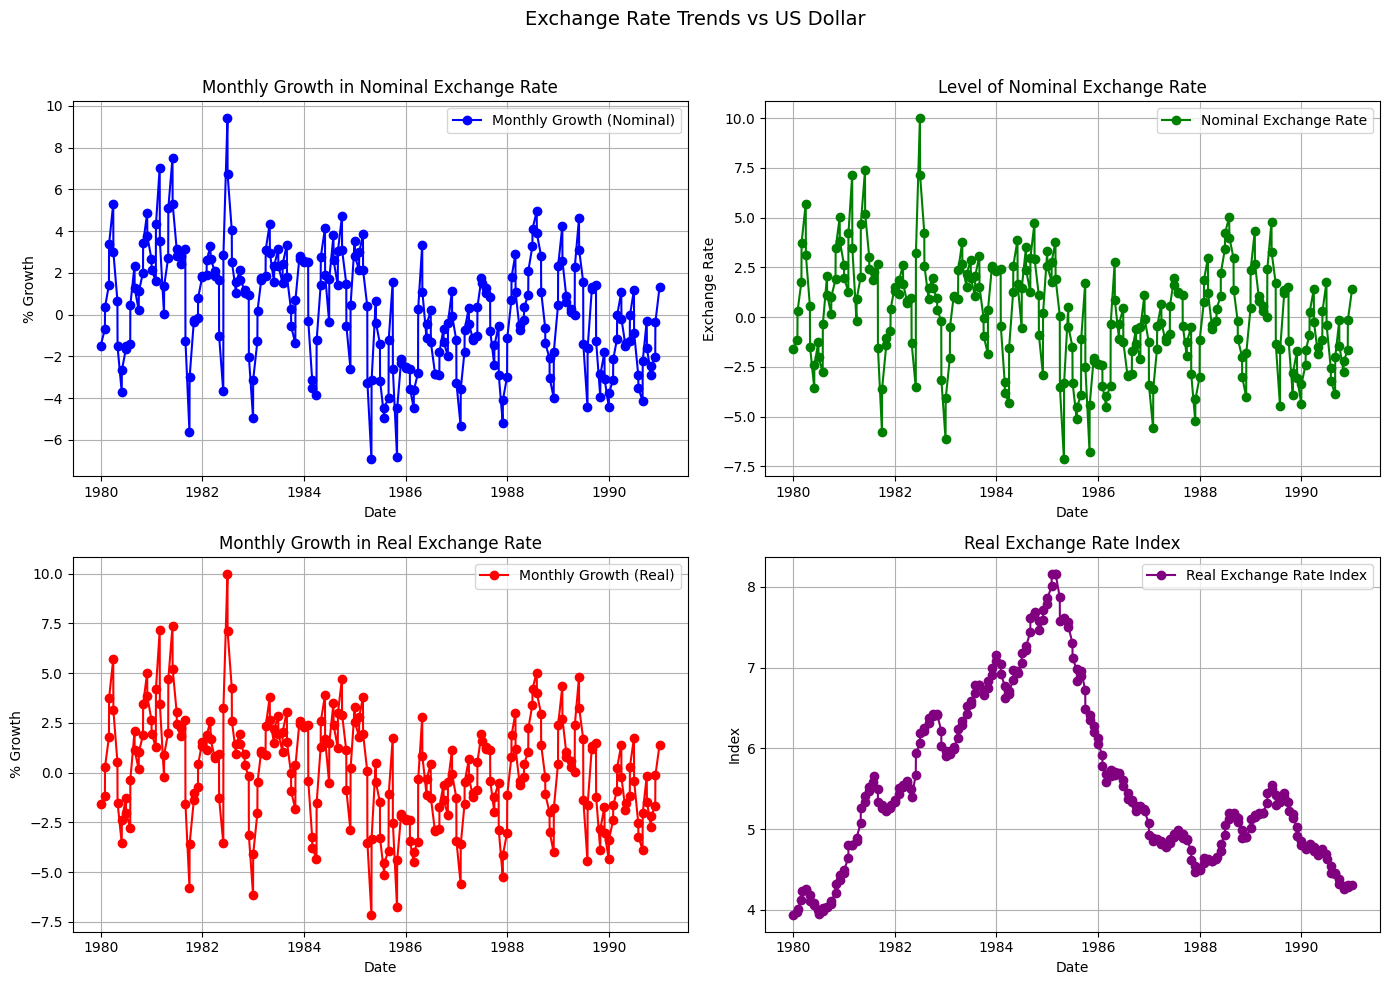

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Load merged dataset
file_path = "../Data/full_merged_dataset.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Drop missing values or interpolate
merged_df = merged_df.interpolate()

# Focus on recent years
merged_df = merged_df[merged_df["Date"] >= "1980-01-01"]

# Plot time series graphs
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Exchange Rate Trends vs US Dollar", fontsize=14)

# 1. Monthly Growth in Nominal Exchange Rate
if "Growth (%)" in merged_df.columns:
    axes[0, 0].plot(merged_df["Date"], merged_df["Growth (%)"], label="Monthly Growth (Nominal)", color="blue", marker="o")
    axes[0, 0].set_title("Monthly Growth in Nominal Exchange Rate")
    axes[0, 0].set_ylabel("% Growth")
    axes[0, 0].legend()

# 2. Level of Nominal Exchange Rate
if "Real Exchange Rate Growth (%)" in merged_df.columns:
    axes[0, 1].plot(merged_df["Date"], merged_df["Real Exchange Rate Growth (%)"], label="Nominal Exchange Rate", color="green", marker="o")
    axes[0, 1].set_title("Level of Nominal Exchange Rate")
    axes[0, 1].set_ylabel("Exchange Rate")
    axes[0, 1].legend()

# 3. Monthly Growth in Real Exchange Rate
if "Real Exchange Rate Growth (%)" in merged_df.columns:
    axes[1, 0].plot(merged_df["Date"], merged_df["Real Exchange Rate Growth (%)"], label="Monthly Growth (Real)", color="red", marker="o")
    axes[1, 0].set_title("Monthly Growth in Real Exchange Rate")
    axes[1, 0].set_ylabel("% Growth")
    axes[1, 0].legend()

# 4. Real Exchange Rate Index
if "RER Index" in merged_df.columns:
    axes[1, 1].plot(merged_df["Date"], merged_df["RER Index"], label="Real Exchange Rate Index", color="purple", marker="o")
    axes[1, 1].set_title("Real Exchange Rate Index")
    axes[1, 1].set_ylabel("Index")
    axes[1, 1].legend()

# Formatting
for ax in axes.flat:
    ax.set_xlabel("Date")
    ax.grid(True)
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Index(['Date', 'RER Index', 'Growth (%)', 'Real Exchange Rate Growth (%)',
       'France Inflation (%)', 'US Inflation (%)', 'France IP Growth (%)',
       'US IP Growth (%)', 'France YoY IP Growth (%)', 'US YoY IP Growth (%)',
       'France Reserves Index', 'US Reserves Index_x', 'US Inflation Rate (%)',
       'US Reserves Index_y'],
      dtype='object')
        Date  RER Index  Growth (%)  Real Exchange Rate Growth (%)  \
0 1959-12-01   6.520281         NaN                            NaN   
1 1959-12-31        NaN         NaN                            NaN   
2 1960-01-01   6.413193         NaN                            NaN   
3 1960-01-31        NaN         0.0                      -1.642377   
4 1960-02-01   6.420277         NaN                            NaN   

   France Inflation (%)  US Inflation (%)  France IP Growth (%)  \
0                   NaN               NaN                   NaN   
1                   NaN               NaN                   NaN   
2               

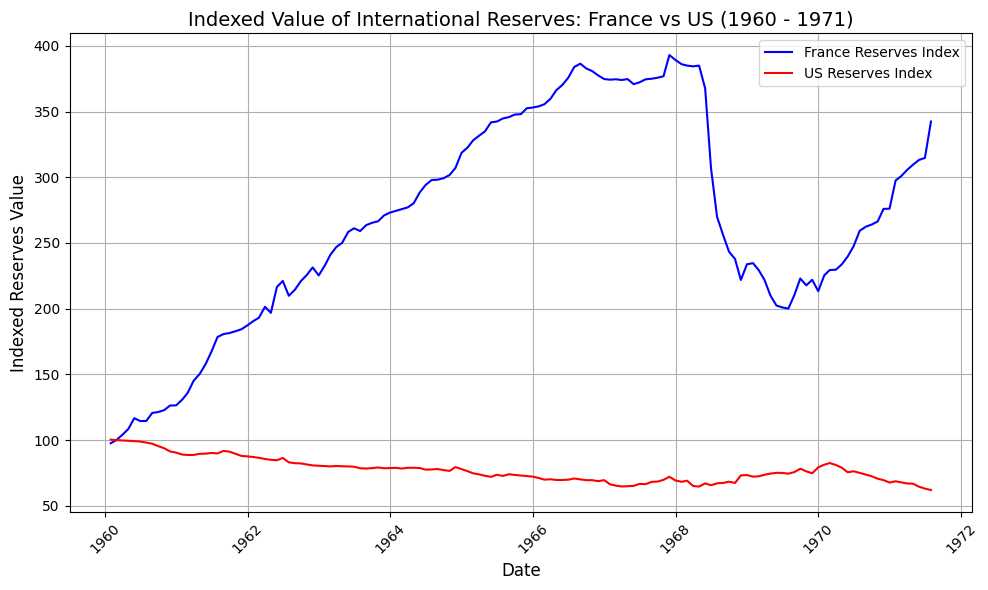

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged dataset
file_path = "../Data/full_merged_dataset.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Check the column names and the first few rows to verify reserves columns
print(merged_df.columns)
print(merged_df.head())

# Filter data for the time period from January 1960 to August 15, 1971 (US exit from Bretton Woods)
start_date = "1960-01-01"
end_date = "1971-08-15"
filtered_df = merged_df[(merged_df["Date"] >= start_date) & (merged_df["Date"] <= end_date)]

# Check if the filtered DataFrame is empty and how many rows it has
print(filtered_df.shape)
print(filtered_df.head())

# Drop rows with missing values in the reserves columns
filtered_df = filtered_df.dropna(subset=["France Reserves Index", "US Reserves Index_x"])

# Plot the indexed value of international reserves for France and the US
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(filtered_df["Date"], filtered_df["France Reserves Index"], label="France Reserves Index", color="blue")
ax.plot(filtered_df["Date"], filtered_df["US Reserves Index_x"], label="US Reserves Index", color="red")

# Title and labels
ax.set_title("Indexed Value of International Reserves: France vs US (1960 - 1971)", fontsize=14)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Indexed Reserves Value", fontsize=12)
ax.legend()

# Formatting
ax.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

# Show plot
plt.show()


# 5.2.2

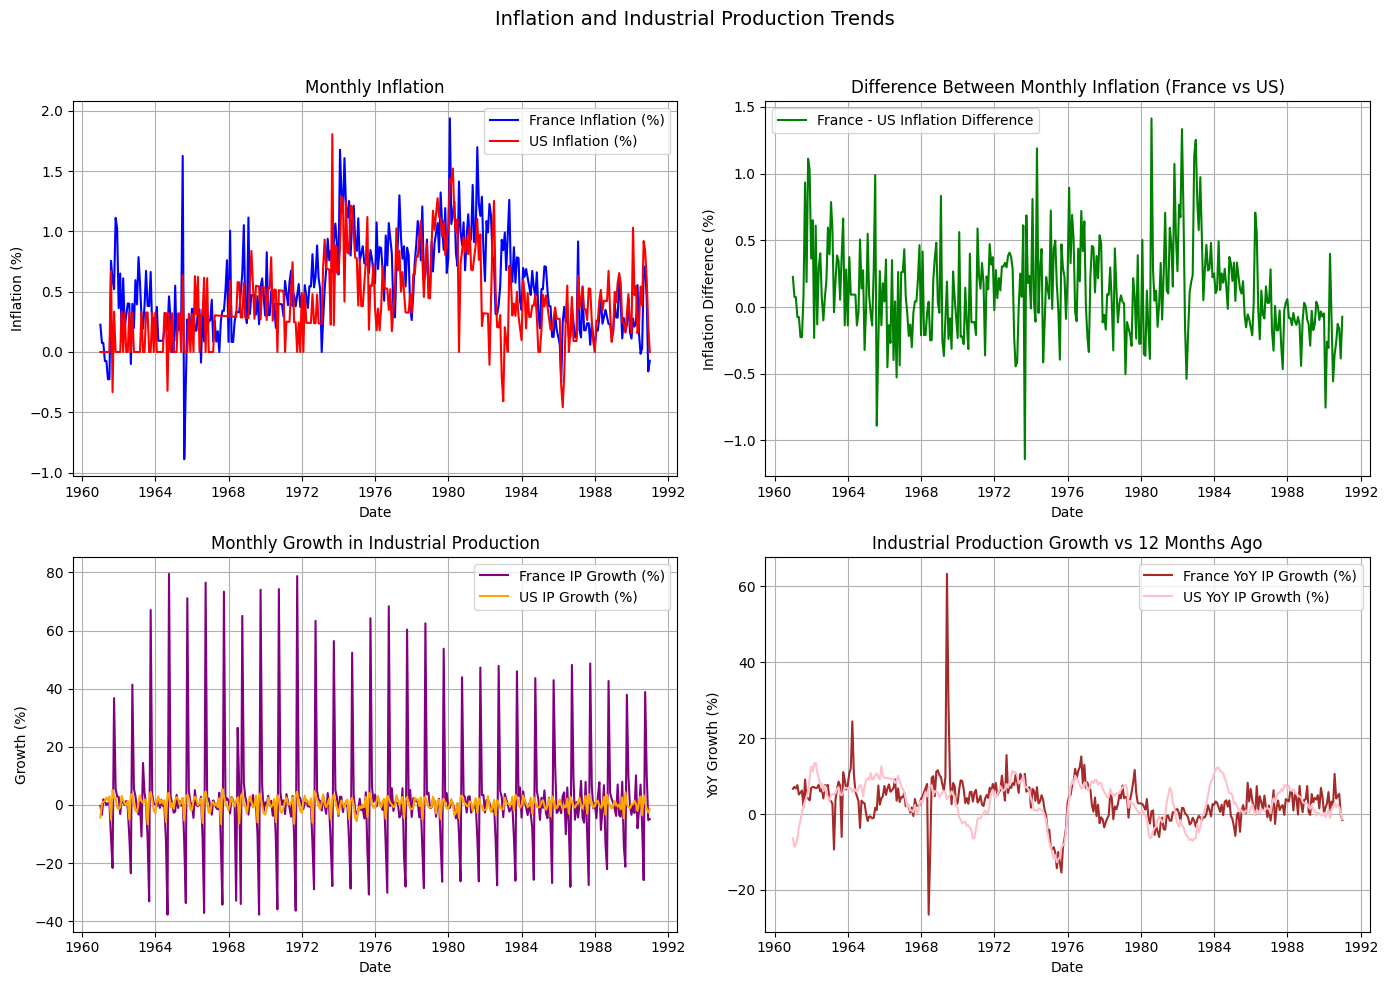

In [98]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the merged dataset
file_path = "../Data/full_merged_dataset.csv"
merged_df = pd.read_csv(file_path)

# Convert Date column to datetime format
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

# Drop rows with missing values in the relevant columns
merged_df = merged_df.dropna(subset=["France Inflation (%)", "US Inflation Rate (%)", 
                                     "France IP Growth (%)", "US IP Growth (%)", 
                                     "France YoY IP Growth (%)", "US YoY IP Growth (%)"])

# Plot time series graphs for inflation and industrial production
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Inflation and Industrial Production Trends", fontsize=14)

# 1. Monthly Inflation (France and US)
axes[0, 0].plot(merged_df["Date"], merged_df["France Inflation (%)"], label="France Inflation (%)", color="blue")
axes[0, 0].plot(merged_df["Date"], merged_df["US Inflation Rate (%)"], label="US Inflation (%)", color="red")
axes[0, 0].set_title("Monthly Inflation")
axes[0, 0].set_ylabel("Inflation (%)")
axes[0, 0].legend()

# 2. Difference Between Monthly Inflation (France vs US)
merged_df["Inflation Difference"] = merged_df["France Inflation (%)"] - merged_df["US Inflation Rate (%)"]
axes[0, 1].plot(merged_df["Date"], merged_df["Inflation Difference"], label="France - US Inflation Difference", color="green")
axes[0, 1].set_title("Difference Between Monthly Inflation (France vs US)")
axes[0, 1].set_ylabel("Inflation Difference (%)")
axes[0, 1].legend()

# 3. Monthly Growth in Industrial Production (France and US)
axes[1, 0].plot(merged_df["Date"], merged_df["France IP Growth (%)"], label="France IP Growth (%)", color="purple")
axes[1, 0].plot(merged_df["Date"], merged_df["US IP Growth (%)"], label="US IP Growth (%)", color="orange")
axes[1, 0].set_title("Monthly Growth in Industrial Production")
axes[1, 0].set_ylabel("Growth (%)")
axes[1, 0].legend()

# 4. Industrial Production Growth Compared to 12 Months Ago (France and US)
axes[1, 1].plot(merged_df["Date"], merged_df["France YoY IP Growth (%)"], label="France YoY IP Growth (%)", color="brown")
axes[1, 1].plot(merged_df["Date"], merged_df["US YoY IP Growth (%)"], label="US YoY IP Growth (%)", color="pink")
axes[1, 1].set_title("Industrial Production Growth vs 12 Months Ago")
axes[1, 1].set_ylabel("YoY Growth (%)")
axes[1, 1].legend()

# Formatting
for ax in axes.flat:
    ax.set_xlabel("Date")
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit the title
plt.show()


# MZ'S UPDATED CODE ENDS HERE

In [84]:
import pandas as pd
import sqlite3
import json
import numpy as np
from lets_plot import *
LetsPlot.setup_html()
import datetime

In [85]:
df_graph_1 = pd.read_json('../Data/monthly_nominal_exchange_rate_growth.json')

# Display the first few rows
display(df_graph_1.head())

,Month,Growth (%)
0,1,NaN
1,2,0.0
2,3,0.0
3,4,0.0
4,5,0.0


In [86]:
df_graph_1['Growth (%)'] = pd.to_numeric(df_graph_1['Growth (%)'], errors='coerce')
df_graph_1 = df_graph_1.dropna(subset=['Growth (%)'])
df_graph_1['Growth (%)'].fillna(0, inplace=True)

a =   ggplot(df_graph_1, aes(x='Month', y='Growth (%)')) + \
        geom_line(color='blue', size=1) + \
        labs(title='Monthly Nominal Growth Over Time', x='Month', y='Growth (%)') + \
        ggsize(800, 400)

display(a)

C:\Users\Xueli\AppData\Local\Temp\ipykernel_16996\610503480.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_graph_1['Growth (%)'].fillna(0, inplace=True)


In [87]:
nominal_rate_df = pd.read_excel(file_path, header=1, engine="openpyxl")
nominal_rate_df.columns = nominal_rate_df.columns.astype(str)

# Select only relevant columns (not four-digit years) and filter for France Exchange Rates
monthly_cols = [x for x in nominal_rate_df.columns if not (x.strip().isdigit() and len(x.strip()) == 4)]
filtered_df = nominal_rate_df.loc[(nominal_rate_df.iloc[:, 0] == 'France') & 
                      (nominal_rate_df.iloc[:, 1].str.contains('Exchange Rates', na=False)), monthly_cols]

# Melt and reshape the data
df_graph_2 = pd.melt(filtered_df, id_vars=['Unnamed: 0', 'Unnamed: 1'], 
                    var_name='Date', value_name='Exchange Rate')[['Date', 'Exchange Rate']]

# Display the result
display(df_graph_2.head())

BadZipFile: File is not a zip file

In [ ]:
df_graph_2['Exchange Rate'] = pd.to_numeric(df_graph_2['Exchange Rate'], errors='coerce')
df_graph_2 = df_graph_2.dropna(subset=['Exchange Rate'])
df_graph_2['Exchange Rate'].fillna(0, inplace=True)

b =   ggplot(df_graph_2, aes(x='Date', y='Exchange Rate')) + \
        geom_line(color='red', size=1) + \
        labs(title='Monthly Nominal Exchange Rate Over Time', x='Date', y='Nominal Exchange Rate') + \
        ggsize(800, 400)

display(b)

In [ ]:
df_graph_3 = pd.read_json('../Data/monthly_real_exchange_rate_growth.json')

# Display the first few rows
display(df_graph_3.head())

In [ ]:
df_graph_3['Real Exchange Rate Growth (%)'] = pd.to_numeric(df_graph_3['Real Exchange Rate Growth (%)'], errors='coerce')
df_graph_3 = df_graph_3.dropna(subset=['Real Exchange Rate Growth (%)'])
df_graph_3['Real Exchange Rate Growth (%)'].fillna(0, inplace=True)

c =   ggplot(df_graph_3, aes(x='Month', y='Real Exchange Rate Growth (%)')) + \
        geom_line(color='Green', size=1) + \
        labs(title='Monthly Real Growth Over Time', x='Month', y='Real Exchange Rate Growth (%)') + \
        ggsize(800, 400)

display(c)

In [ ]:
df_graph_4 = pd.read_json('../Data/real_exchange_rate_index.json')

display(df_graph_4)

In [ ]:
df_graph_4['RER Index'] = pd.to_numeric(df_graph_4['RER Index'], errors='coerce')
df_graph_4 = df_graph_4.dropna(subset=['RER Index'])
df_graph_4['RER Index'].fillna(0, inplace=True)

d =   ggplot(df_graph_4, aes(x='Date', y='RER Index')) + \
        geom_line(color='Magenta', size=1) + \
        labs(title='Real Exchange Rate Index', x='Date', y='RER Index') + \
        ggsize(800, 400)

display(d)

In [ ]:
gggrid([a, b, c, d], ncol=2) + ggsize(900, 600)

Putting all 4 graphs to one graph

In [ ]:
df_graph_4['Date'] = pd.to_datetime(df_graph_4['Date'], unit='ms')

# Convert month numbers to datetime, assuming they start from Dec 1959
df_graph_1['Month'] = pd.to_numeric(df_graph_1['Month'], errors='coerce')

# Convert month numbers to datetime
start_date = pd.to_datetime('1959-12-01')
df_graph_1['Date'] = start_date + pd.to_timedelta((df_graph_1['Month'] - 1) * 30, unit='D')

df_graph_3['Month'] = pd.to_numeric(df_graph_3['Month'], errors='coerce')
df_graph_3['Date'] = start_date + pd.to_timedelta((df_graph_3['Month'] - 1) * 30, unit='D')

# Convert string dates to datetime for df_graph_2
df_graph_2['Date'] = pd.to_datetime(df_graph_2['Date'], format='%b %Y')

display(df_graph_4.tail())

In [ ]:
df_graph_1_2 = df_graph_1.drop(['Month'], errors='ignore')
df_graph_2_2 = df_graph_2.drop(['Date'], axis=1)
df_graph_3_2 = df_graph_3.drop(['Month'], errors='ignore')
df_graph_3_3 = df_graph_3_2.drop(['Date'], axis=1)
df_graph_4_2 = df_graph_4.drop(['Date'], axis=1)

# Ensure Date columns are in datetime format
df_graph_1_2['Date'] = pd.to_datetime(df_graph_1['Date'])

display(df_graph_3_3.tail())

In [ ]:
# Ensure Date columns are in datetime format
df_graph_1['Date'] = pd.to_datetime(df_graph_1['Date'])

combined_df = pd.concat([df_graph_4_2, df_graph_3_3, df_graph_2_2, df_graph_1_2], axis=1)

display(combined_df)

In [ ]:
melted_df = combined_df.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

p = ggplot(melted_df, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Combined Exchange Rate and Growth Metrics Over Time') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta']) + \
    ggsize(900, 450)

p

## 5.2.2 Inflation and Industrial Production Graphs
 Plot the following time series graphs, presenting the inflation graphs together and the industrial production graphs together:

 • Monthly inflation.

 • The difference between monthly inflation in your country versus the US.

 • The monthly growth in industrial production.

 • The growth in industrial production versus 12 months ago.

 Why are your results for the monthly versus 12 monthly growth in industrial production so different?
 Which measure is more useful?

In [ ]:
Monthly_inflation_graph_df = pd.read_json('../Data/Monthly_inflation.json')

display(Monthly_inflation_graph_df.head())


In [ ]:
Monthly_inflation_graph_df['US-France Inflation Difference'] = Monthly_inflation_graph_df['France Inflation (%)'] - Monthly_inflation_graph_df['US Inflation (%)']

start_date = pd.to_datetime('1959-12-01')
Monthly_inflation_graph_df['Date'] = start_date + pd.to_timedelta((Monthly_inflation_graph_df['Month'] - 1) * 30, unit='D')

Monthly_inflation_graph_df_2 = Monthly_inflation_graph_df.drop(['Month'], axis=1)

display(Monthly_inflation_graph_df_2.head())

In [ ]:
Monthly_growth_graph_df = pd.read_json('../Data/Montly_industrial_production.json')

start_date = pd.to_datetime('1959-12-01')
Monthly_growth_graph_df['Date'] = start_date + pd.to_timedelta((Monthly_growth_graph_df['Month'] - 1) * 30, unit='D')

Monthly_inflation_graph_df_2 = Monthly_inflation_graph_df.drop(['Month'], axis=1)

Monthly_growth_graph_df_2 = Monthly_growth_graph_df.drop(['Month'], axis=1)

display(Monthly_growth_graph_df_2.head())

In [ ]:
Growth_vs_12_months_df = pd.read_json('../Data/YoY_growth.json')

Growth_vs_12_months_df_2 = Growth_vs_12_months_df.drop(['Month'], axis=1)

display(Growth_vs_12_months_df_2.tail())

In [ ]:
combined_df = pd.concat([Growth_vs_12_months_df_2, Monthly_growth_graph_df_2], axis=1)

display(combined_df.head())

In [ ]:
melted_df = combined_df.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

Industrial_Production_graphs = ggplot(melted_df, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Industrial Production data') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta', 'black', 'pink', 'yellow']) + \
    ggsize(1200, 600)

Industrial_Production_graphs

In [ ]:
melted_df_2 = Monthly_inflation_graph_df_2.melt(id_vars='Date', 
                               var_name='Metric', 
                               value_name='Value')

bretton_woods_end = pd.to_datetime('1971-08-01').timestamp() * 1000

Inflation_graphs = ggplot(melted_df_2, aes(x='Date', y='Value', color='Metric')) + \
    geom_line() + \
    geom_vline(xintercept=bretton_woods_end, color='black', linetype='dashed', size=1) + \
    ggtitle('Inflation Data') + \
    scale_color_manual(values=['blue', 'red', 'green', 'magenta', 'black', 'pink', 'yellow']) + \
    ggsize(1200, 600)

Inflation_graphs

# q6

In [ ]:
# Load the dataset
file_path = "../Data/International_Financial_Statistics_ UK and Germany.xlsx"  # Update this with your actual file path
q6_data = pd.read_excel(file_path, header=None, engine="openpyxl")

q6_data

In [ ]:
us_cpi_row1 = q6_data.iloc[8, 2:]
us_cpi_list = us_cpi_row1.tolist()

In [ ]:
german_exchange_rate_row = q6_data.iloc[3, 2:]  # The exchange rates start from the 3rd column (index 2)
german_cpi_row = q6_data.iloc[4, 2:]

# Convert the exchange rates and cpi into a list
german_exchange_rate_list = german_exchange_rate_row.tolist()
german_cpi_list = german_cpi_row.tolist()

In [ ]:
uk_exchange_rate_row = q6_data.iloc[6, 2:]  # The exchange rates start from the 3rd column (index 2)
uk_cpi_row = q6_data.iloc[7, 2:]

# Convert the exchange rates and cpi into a list
uk_exchange_rate_list = uk_exchange_rate_row.tolist()
uk_cpi_list = uk_cpi_row.tolist()

In [ ]:
# finding the german real exchange rate
german_nominal = pd.Series(german_exchange_rate_list)
us_cpi_pandas = pd.Series(us_cpi_list)
german_cpi_pandas = pd.Series(german_cpi_list)
german_rer = german_nominal * (us_cpi_pandas / german_cpi_pandas)

In [ ]:
# finding the uk real exchange rate
uk_nominal = pd.Series(uk_exchange_rate_list)
us_cpi_pandas = pd.Series(us_cpi_list)
uk_cpi_pandas = pd.Series(uk_cpi_list)
uk_rer = uk_nominal * (us_cpi_pandas / uk_cpi_pandas)

In [ ]:
# gbp to gdm (german deutsche mark) exchange rate 
gbp_to_german = [gbp / eur for gbp, eur in zip(german_nominal, uk_nominal)]

In [ ]:
# finding the date as a panda table 
date_row1 = q6_data.iloc[1, 2:]
date_list1 = date_row1.tolist()

In [ ]:
gbp_to_gdm = pd.DataFrame({
    'Date': date_list1,
    'GBP_to_GDM': gbp_to_german
})

gbp_to_gdm

In [ ]:
plot = ggplot(gbp_to_gdm) + \
    geom_line(aes(x='Date', y='GBP_to_GDM'), color='blue') + \
    labs(title="GBP to German Exchange Rate", x="Date", y="Exchange Rate") + \
    theme_minimal()

plot.show()

In [ ]:
uk_rer_table = pd.DataFrame({
    'Date': date_list1,
    'uk_rer': uk_rer 

})

In [ ]:
plot2 = ggplot(uk_rer_table) + \
    geom_line(aes(x='Date', y='uk_rer'), color='blue') + \
    labs(title="UK Real Exchange Rate", x="Date", y="Real Exchange Rate") + \
    theme_minimal()
plot2.show()

inflation difference (for point 3) and inflation of the uk (for point 4)

In [ ]:
uk_inflation = uk_cpi_pandas.pct_change() * 100
uk_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'uk_inflation': uk_inflation
})
uk_inflation_table

germany_inflation = german_cpi_pandas.pct_change() * 100
germany_inflation_table = pd.DataFrame({
    'Date': date_list1,
    'germany_inflation': germany_inflation

})

In [ ]:
inflation_table = pd.merge(uk_inflation_table, germany_inflation_table, on='Date')

# Melt the DataFrame to have 'Source' as a categorical variable for coloring
inflation_table_melted = pd.melt(inflation_table, id_vars=["Date"], 
                                 value_vars=["uk_inflation", "germany_inflation"],
                                 var_name="Country", value_name="Inflation")

# Setup lets-plot for HTML rendering


# Create the plot
plot5 = ggplot(inflation_table_melted) + \
    geom_line(aes(x='Date', y='Inflation', color='Country'), size=1) + \
    labs(title="UK vs Germany Inflation", x="Date", y="Inflation (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_inflation": "red", "germany_inflation": "blue"})  # Set the colors for each country

# Display the plot
plot5.show()

In [ ]:
uk_industrial_production_row = q6_data.iloc[5, 2:]
uk_industrial_production_list = uk_industrial_production_row.tolist()
uk_industrial_production_pandas =pd.Series(uk_industrial_production_list)
uk_ip_growth = uk_industrial_production_pandas.pct_change() * 100

germany_industrial_production_row = q6_data.iloc[2, 2:]
germany_industrial_production_list = germany_industrial_production_row.tolist()
germany_industrial_production_pandas = pd.Series(germany_industrial_production_list)
germany_ip_growth = germany_industrial_production_pandas.pct_change() * 100 

In [ ]:
uk_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'uk_ip_growth': uk_ip_growth
})

germany_ip_growth_table = pd.DataFrame({
    'Date': date_list1,
    'germany_ip_growth': germany_ip_growth
})

growth_table = pd.merge(germany_ip_growth_table, uk_ip_growth_table, on='Date')

In [ ]:
# Melt the DataFrame to long format for ggplot
growth_table_melted = pd.melt(growth_table, id_vars=["Date"], 
                              value_vars=["uk_ip_growth", "germany_ip_growth"], 
                              var_name="Country", value_name="IP_Growth")

# Create the plot
plot = ggplot(growth_table_melted) + \
    geom_line(aes(x='Date', y='IP_Growth', color='Country'), size=1) + \
    labs(title="UK vs Germany Industrial Production Growth", x="Date", y="Industrial Production Growth (%)") + \
    theme_minimal() + \
    scale_color_manual(values={"uk_ip_growth": "red", "germany_ip_growth": "blue"})  # Set the colors for each country

# Display the plot
plot.show()